In [1]:
## Long Short Term Memory (LSTM) Recurrent Neural Network (RNN)

## This program considers the past 60 day stock price for predictions.

## Current features are daily Close, Open, High, Low, and Volume. These will likely be tweaked in subsequent analyses over time to possible include:
#   Difference between 50 day moving average and 200 day moving average
#   52 week high, low, moving average
#   Difference between 52 week average volume and current volume


In [2]:
# !pip install --upgrade pandas-datareader
# !pip install yfinance

<h1>Importing Dependencies</h1>

In [3]:
# Imports

import math
import pandas_datareader.data as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Flatten
from keras import optimizers, callbacks
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('fivethirtyeight')


<h1>Gathering Data</h1>

In [4]:
# Data gathering
import yfinance as yf
yf.pdr_override()
df = web.get_data_yahoo('MSFT', start='2017-01-01', end='2023-09-10')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,62.790001,62.840000,62.130001,62.580002,57.138729,20694100
2017-01-04,62.480000,62.750000,62.119999,62.299999,56.883068,21340000
2017-01-05,62.189999,62.660000,62.029999,62.299999,56.883068,24876000
2017-01-06,62.299999,63.150002,62.040001,62.840000,57.376125,19922900
2017-01-09,62.759998,63.080002,62.540001,62.639999,57.193508,20382700
...,...,...,...,...,...,...
2023-09-01,331.309998,331.989990,326.779999,328.660004,327.994293,14931200
2023-09-05,329.000000,334.850006,328.660004,333.549988,332.874359,18553900
2023-09-06,333.380005,334.459991,330.179993,332.880005,332.205750,17535800


In [5]:
# Retrieve matrix dimensions: (# rows, # columns)
df.shape

(1682, 6)

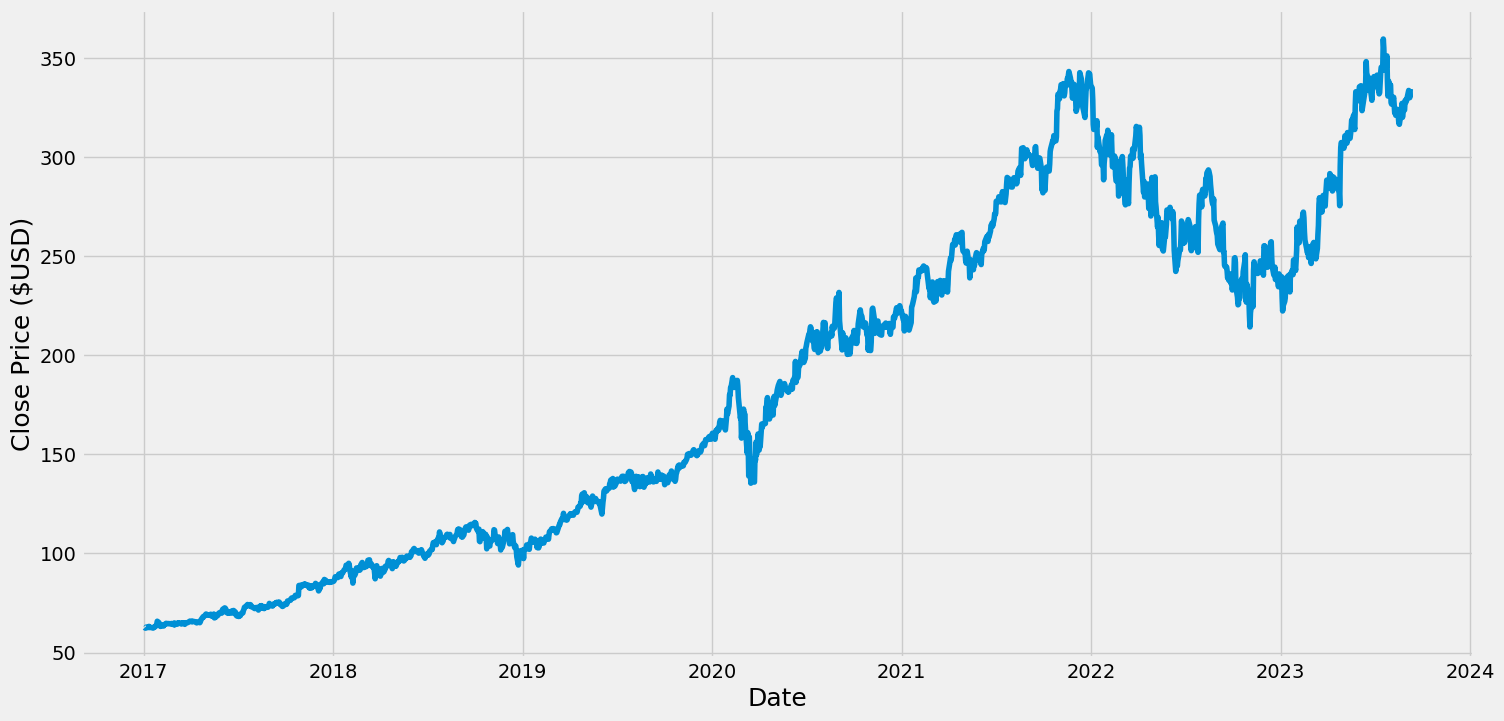

In [6]:
# Visualize closing prices of gathered historic data

plt.figure(figsize=(16,8))
plt.title='Close Price History'
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ($USD)', fontsize=18)

plt.show()

<h1>Data Preprocessing</h1>

In [7]:
# Data preprocessing

# Filter to relevant features only
df_train = df.filter(['Close', 'Open', 'High', 'Low', 'Volume'])


# Isolate dates as independent variables. This may be redundant later but useful in attaching dates to final predictions.
date_train = df.index.strftime("%Y-%m-%d").tolist()
date_train = [pd.to_datetime(d) for d in date_train]

# Convert dataframe to a numpy array
dataset = df_train.values

# Compute row count to train the model on => 80% of data for training
training_data_len = math.ceil(len(dataset) * 0.8)
print(training_data_len)

1346


In [8]:
# Scale the data for preprocessing. Simply normalizes each column's values from 0:1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np.float32(df_train))  

open_price_scaler  = MinMaxScaler(feature_range=(0,1))
scaled_open_prices = open_price_scaler.fit_transform(np.float32(df_train.filter(['Open'])))

df_train_scaled = scaled_data[0:training_data_len, :]
df_train = df_train[0:training_data_len]
date_train = df_train.index.strftime("%Y-%m-%d").tolist()
date_train = [pd.to_datetime(d) for d in date_train]

x_train = []
y_train = []
batch_size = 60
forecast_size = 1

# Columns in place --> 0: Close, 1: Open, 2: High, 3: Low, 4: Volume
for i in range(batch_size, len(df_train_scaled)-forecast_size+1):
    x_train.append(df_train_scaled[i-batch_size:i, :])        # All features at positions 0 to 59
    y_train.append(df_train_scaled[i+forecast_size-1:i+forecast_size,1])        # Open at position 60
  
# Convert x_train and y_train to numpy arrays
Lstm_x, Lstm_y = np.array(x_train), np.array(y_train)

In [9]:
# Reshape the x_train data set => Add third column
# Lstm_x = np.reshape(Lstm_x, (Lstm_x.shape[0], Lstm_x.shape[1], 1))
Lstm_x.shape

(1286, 60, 5)

<h1>Define the Models</h1>

In [10]:
# Build the LSTM Model(s)
print('y.shape[1]: ', Lstm_y.shape[1])
print('x.shape[1]: ', Lstm_x.shape[1])
print('x.shape[2]: ', Lstm_x.shape[2])

x, y = Lstm_x, Lstm_y

lstm_fallback_model = Sequential()
lstm_fallback_model.add(LSTM(64, activation='relu', input_shape=(
    x.shape[1], x.shape[2]),  return_sequences=True))
lstm_fallback_model.add(Dropout(0.2))
lstm_fallback_model.add(BatchNormalization())
lstm_fallback_model.add(LSTM(32, activation='relu', return_sequences=False))
lstm_fallback_model.add(Dropout(0.2))
lstm_fallback_model.add(BatchNormalization())
lstm_fallback_model.add(Dense(32, activation='relu'))
lstm_fallback_model.add(Dense(y.shape[1], activation='relu'))
opt = optimizers.legacy.Adam(lr=0.001, decay=1e-6)
lstm_fallback_model.compile(
    loss='mse',
    optimizer=opt,
    metrics=['mae']
)
es = callbacks.EarlyStopping(
    monitor='loss', patience=15, restore_best_weights=True)
lstm_fallback_model.fit(x, y, epochs=16, verbose=1, callbacks=[
                        es], validation_split=0.1, batch_size=1)
lstm_fallback_model.summary()


Lstm_model1 = Sequential()
Lstm_model1.add(LSTM(units=64, return_sequences=True,
                input_shape=(x.shape[1], x.shape[2])))
Lstm_model1.add(Dropout(0.2))
Lstm_model1.add(LSTM(units=50, return_sequences=True))
Lstm_model1.add(Dropout(0.2))
Lstm_model1.add(LSTM(units=50, return_sequences=True))
Lstm_model1.add(Dropout(0.2))
Lstm_model1.add(LSTM(units=50))
Lstm_model1.add(Dropout(0.2))
Lstm_model1.add(Dense(units=1))
Lstm_model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
es = callbacks.EarlyStopping(
    monitor='loss', patience=15, restore_best_weights=True)
Lstm_model1.fit(x, y, epochs=16, validation_split=0.1,
                batch_size=1, verbose=1, callbacks=[es])
Lstm_model1.summary()


y.shape[1]:  1
x.shape[1]:  60
x.shape[2]:  5
Epoch 1/16


/Users/samfriedman/.local/share/virtualenvs/stocks_lstm_local-oIwf4ot9/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1157/1157 [==============================] - 11s 9ms/step - loss: 0.1428 - mae: 0.3021 - val_loss: 9.4560 - val_mae: 2.0600
Epoch 2/16
1157/1157 [==============================] - 10s 9ms/step - loss: 0.1428 - mae: 0.3021 - val_loss: 20.7124 - val_mae: 3.3728
Epoch 3/16
1157/1157 [==============================] - 10s 9ms/step - loss: 0.1428 - mae: 0.3021 - val_loss: 9.6860 - val_mae: 2.0045
Epoch 4/16
1157/1157 [==============================] - 11s 9ms/step - loss: 0.1428 - mae: 0.3021 - val_loss: 8.4839 - val_mae: 1.9000
Epoch 5/16
1157/1157 [==============================] - 10s 9ms/step - loss: 0.1428 - mae: 0.3021 - val_loss: 13.5696 - val_mae: 2.4623
Epoch 6/16
1157/1157 [==============================] - 10s 9ms/step - loss: 0.1428 - mae: 0.3021 - val_loss: 12.3985 - val_mae: 2.2913
Epoch 7/16
1157/1157 [==============================] - 10s 9ms/step - loss: 0.1428 - mae: 0.3021 - val_loss: 17.1464 - val_mae: 2.8201
Epoch 8/16
1157/1157 [==============================] - 10s 9m

<h1>Predicting</h1>

In [11]:
# Create the testing data set

# Array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, 1]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :])

x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(
    x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

In [12]:
# Retrieve models' predicted price values
old_model_predictions = lstm_fallback_model.predict(x_test)
print(old_model_predictions.shape)

random_example_model_predictions = Lstm_model1.predict(x_test)
print(random_example_model_predictions.shape)

# fallback_model_predictions = lstm_fallback_model.predict(x_test)
# print(fallback_model_predictions.shape)

# model1_predictions = Lstm_model1.predict(x_test)
# print(model1_predictions.shape)

# model2_predictions = Lstm_model2.predict(x_test)
# print(model2_predictions.shape)

11/11 [==============================] - 0s 5ms/step
(336, 1)
11/11 [==============================] - 1s 11ms/step
(336, 1)


In [13]:

# Unscale predictions to compare to original closing prices (y_test)
old_model_predictions = open_price_scaler.inverse_transform(
    old_model_predictions)
# Unscale predictions to compare to original closing prices (y_test)
random_example_model_predictions = open_price_scaler.inverse_transform(
    random_example_model_predictions)
# # Unscale predictions to compare to original closing prices (y_test)
# fallback_model_predictions = open_price_scaler.inverse_transform(
#     fallback_model_predictions)
# # Unscale predictions to compare to original closing prices (y_test)
# model1_predictions = open_price_scaler.inverse_transform(model1_predictions)
# # Unscale predictions to compare to original closing prices (y_test)
# model2_predictions = open_price_scaler.inverse_transform(model2_predictions)

In [14]:
# Evaluate root mean square error (RMSE) => Standard deviation of the residuals

old_model_rmse = np.sqrt(np.mean(old_model_predictions - y_test)**2)
random_example_model_rmse = np.sqrt(np.mean(random_example_model_predictions - y_test)**2)
# fallback_model_rmse = np.sqrt(np.mean(fallback_model_predictions - y_test)**2)
# model1_rmse = np.sqrt(np.mean(model1_predictions - y_test)**2)
# model2_rmse = np.sqrt(np.mean(model2_predictions - y_test)**2)

print(old_model_rmse,
      random_example_model_rmse)
      # fallback_model_rmse,
      # model1_rmse,
      # model2_rmse)

901.6130431720188 1.2915034067063105


<h1>Results</h1>

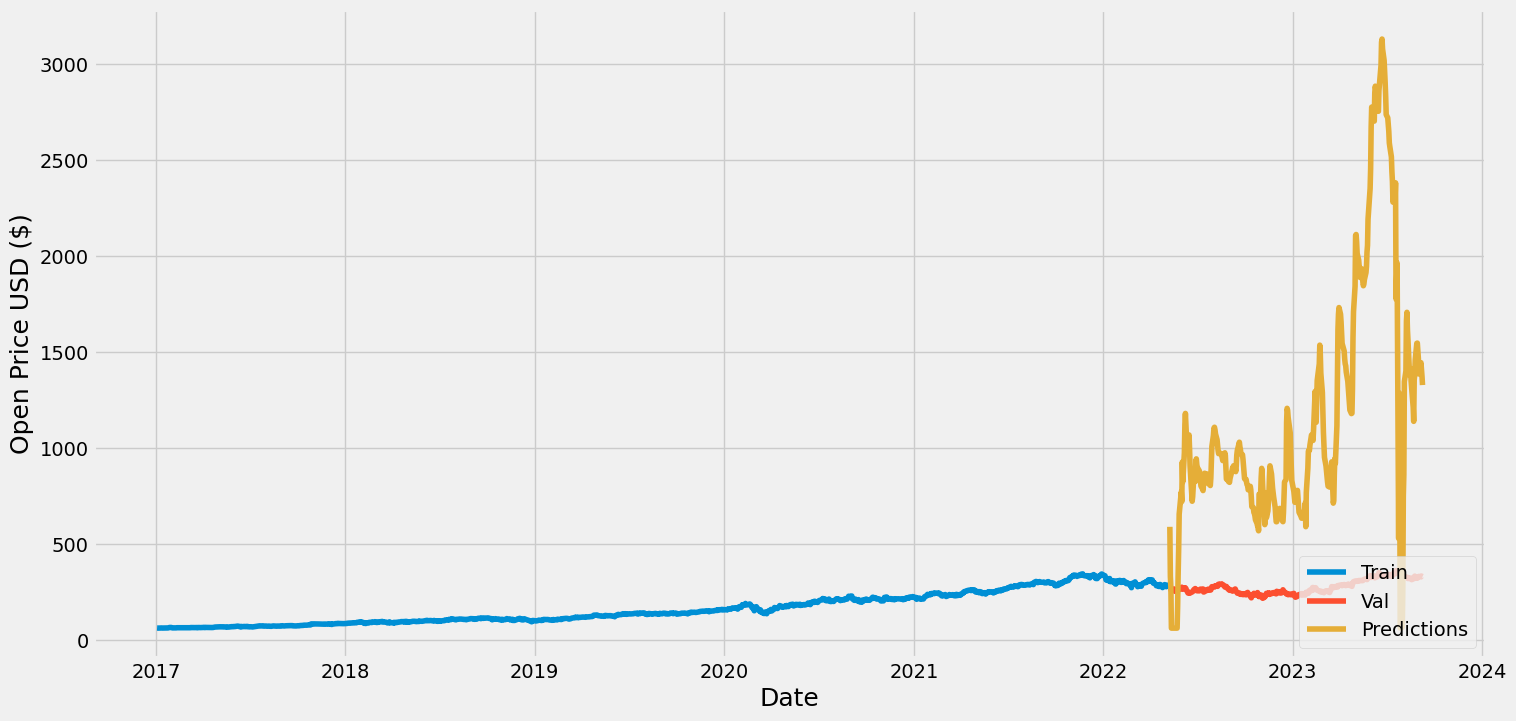

In [15]:
# Plot the data
data = df.filter(['Open'])
train = data[:training_data_len].copy()
valid = data[training_data_len:].copy()

valid['Predictions'] = old_model_predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title='Old Model'
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

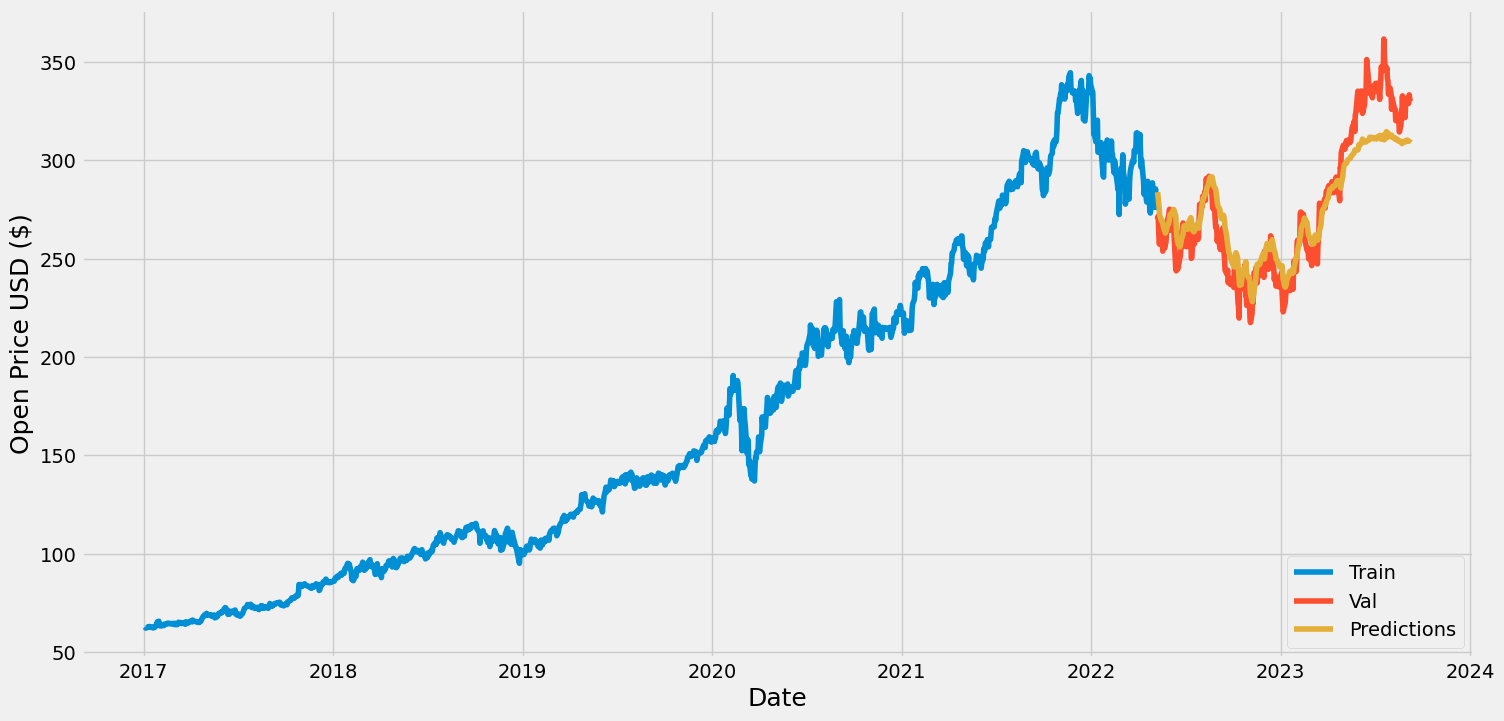

In [16]:
# Plot the data
data1 = df.filter(['Open'])
train1 = data1[:training_data_len].copy()
valid1 = data1[training_data_len:].copy()

valid1['Predictions'] = random_example_model_predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title='Other Model'
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train1['Open'])
plt.plot(valid1[['Open', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<h1>Further Analysis</h1>

In [17]:
# Check model's efficacy at predicting if stock price is higher or lower than previous day
total_days = valid.shape[0]

preds = valid['Predictions'].values
actual_opens = valid['Open'].values

good = 0
bad = 0

for i in range(1, total_days-1):
    actual_dif = preds[i] - preds[i-1]
    predicted_dif = actual_opens[i] - actual_opens[i-1]
    and_signs = (actual_dif > 0 and predicted_dif > 0) or (actual_dif < 0 and predicted_dif < 0)
    
    if and_signs:
        good += 1
    else:
        bad +=1
        
print('good: ', good)
print('bad: ', bad)
    

good:  157
bad:  177


In [18]:
# Check model1's efficacy at predicting if stock price is higher or lower than previous day
total_days = valid1.shape[0]

preds1 = valid1['Predictions'].values
actual_opens1 = valid1['Open'].values

good1 = 0
bad1 = 0

for i in range(1, total_days-1):
    actual_dif = preds1[i] - preds1[i-1]
    predicted_dif = actual_opens1[i] - actual_opens1[i-1]
    and_signs = (actual_dif > 0 and predicted_dif > 0) or (actual_dif < 0 and predicted_dif < 0)
    
    if and_signs:
        good1 += 1
    else:
        bad1 +=1
        
print('good: ', good1)
print('bad: ', bad1)
    

good:  188
bad:  146
